In [1]:
# Imports
import numpy as np
from math import pi
%load_ext cython
%matplotlib inline

In [2]:
%%cython
# Compiling matrix generator
import numpy as np
cimport numpy as cnp
cdef extern from 'complex.h':
    double complex cexp(double complex)
from libc.math cimport sqrt
from math import pi
cdef double PI=pi
cimport cython

@cython.boundscheck(False)
@cython.cdivision(True)
def generator(int block_size, double [:] S, long[:] i, long[:] j,
                      double complex[:,:,:] angle_row, double complex[:,:,:] angle_col):
    cdef long N = i.shape[0], M = j.shape[0], K = S.shape[0]
    result = np.zeros((N, M), dtype=np.complex128)
    cdef double complex[:,:] view = result
    cdef double complex s, w = PI*2.j/block_size
    cdef long ii, jj, k, ti, tj, block_i, block_j
    cdef double complex tmp_i, tmp_j
    for ii in range(N):
        ti = i[ii] % block_size
        block_i = i[ii] / block_size
        for jj in range(M):
            tj = j[jj] % block_size
            block_j = j[jj] / block_size
            for kk in range(K):
                tmp_j = angle_col[block_i, tj, kk].conjugate()
                tmp_i = angle_row[block_j, ti, kk]
                view[ii, jj] += S[kk]*tmp_i*tmp_j
    return result

In [3]:
# Python code for matrix generation and accuracy checks

def gen_rotation(block_size, scale):
    return np.linalg.qr(np.linalg.qr(np.random.randn(block_size, block_size, 2).
            view(np.complex128)[:,:,0])[0]+scale*np.eye(block_size))[0]

def get_matrices(block_size, block_count, rot_scale, decay, tol, norm):
    N = block_size*block_count
    row = np.arange(N, dtype=np.int)
    col = row
    S = decay**-np.arange(block_size)
    angle_row = np.array([np.fft.fft2(gen_rotation(block_size, rot_scale)) for i in range(block_count)])
    angle_col = np.array([np.fft.ifft2(gen_rotation(block_size, rot_scale)) for i in range(block_count)])
    if norm == 'fro':
        S2 = S[::-1]**2
        for i in range(S2.size-1):
            S2[i+1] += S2[i]
        rank = S2.size-S2.searchsorted(S2[-1]*tol*tol, 'left')
    elif norm == 2:
        S2 = S[::-1]
        rank = S2.size-S2.searchsorted(S2[-1]*tol, 'left')
    S2 = S[:rank]
    full_A = generator(block_size, S, row, col, angle_row, angle_col)
    appr_A = generator(block_size, S2, row, col, angle_row, angle_col)
    return full_A, appr_A

In [4]:
# Setting parameters
block_size = 64
block_count = 64
rot_scale = .0
decay = 2.
tol = 1e-3
norm = 'fro'

In [5]:
A, B = get_matrices(block_size, block_count, rot_scale, decay, tol, norm)
test = np.zeros((block_count, block_count))
for i in range(block_count):
    for j in range(block_count):
        block_A = A[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        block_B = B[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        test[i, j] = np.linalg.norm(block_A-block_B, norm)/np.linalg.norm(block_A, norm)

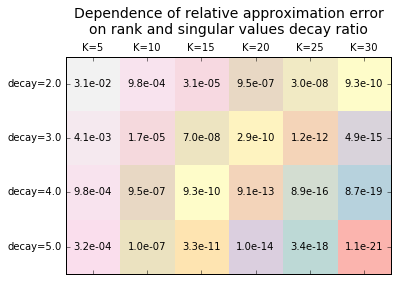

In [7]:
# Some heat map
from pylab import figure, cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
decays = np.linspace(2., 5., 4)
ks = np.arange(5, 35, 5)
C = np.zeros((decays.size, ks.size))
for i in range(decays.size):
    for j in range(ks.size):
        C[i, j] = decays[i]**-ks[j]

f = plt.figure()
ax = f.add_subplot(111)
im = ax.matshow(C, cmap=cm.Pastel1, norm=LogNorm(), interpolation='nearest')
ax.set_xticklabels(['']+['K={}'.format(i) for i in ks])
ax.set_yticklabels(['']+['decay={}'.format(i) for i in decays])
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        ax.text(j, i, '{:.1e}'.format(C[i, j]), va='center', ha='center')
ax.set_title('Dependence of relative approximation error\non rank and singular values decay ratio',
             fontdict={'fontsize':14}, y=1.08)
plt.tight_layout()
plt.savefig('appr_accuracy.pdf')